
Choose visualization mode:
1. Interactive viewer
2. Batch view


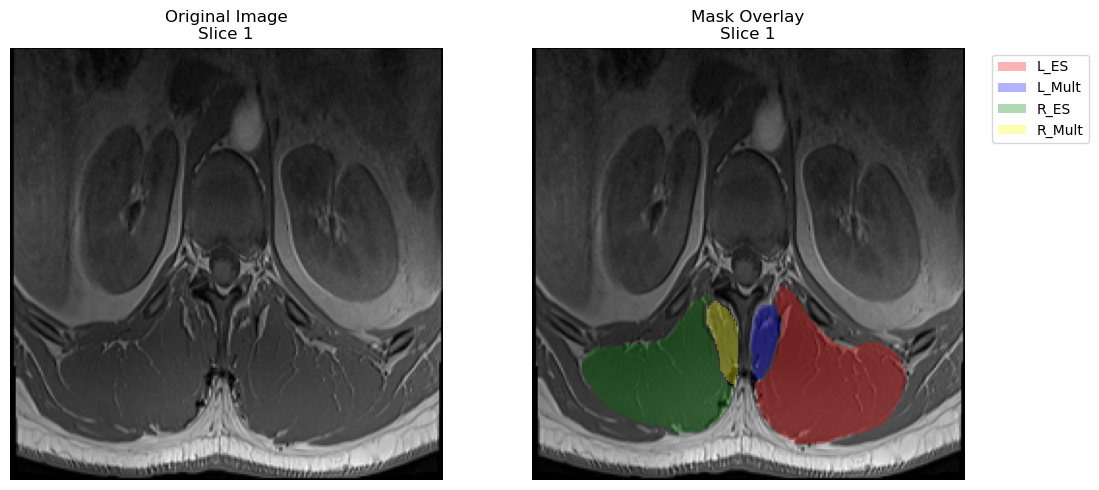

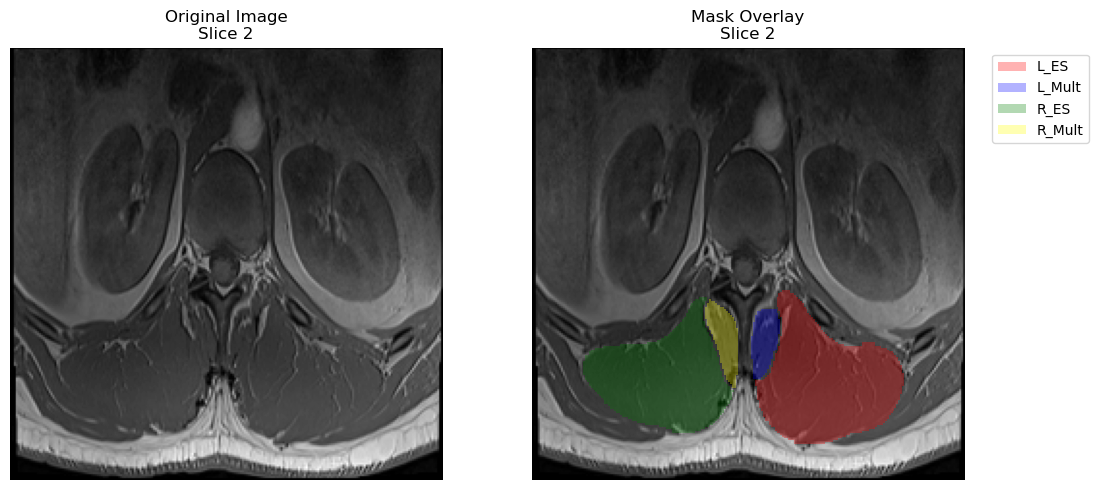

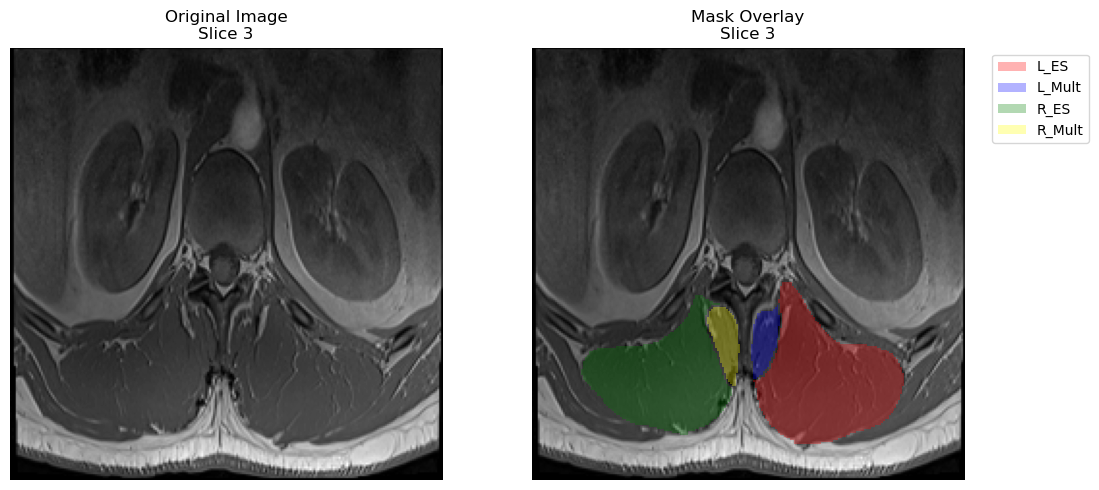

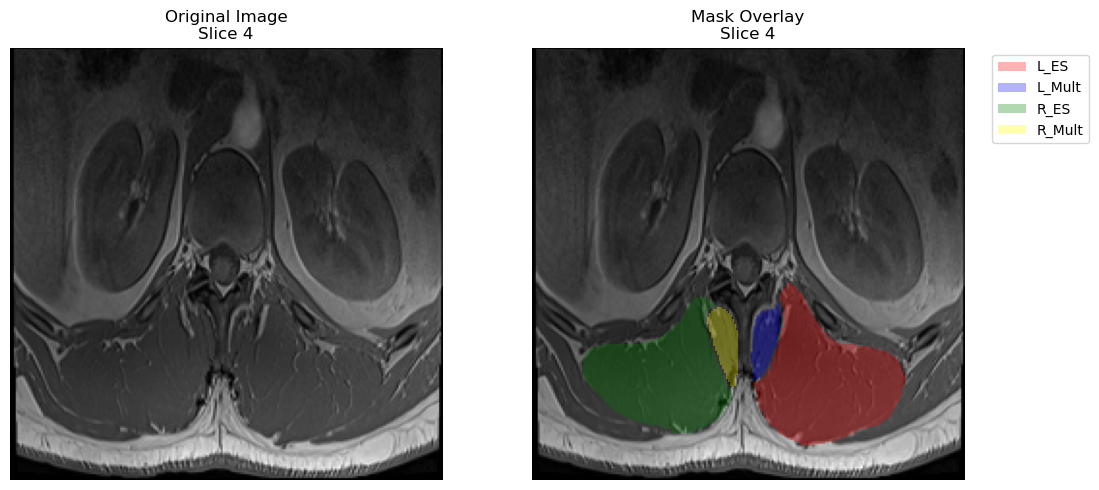

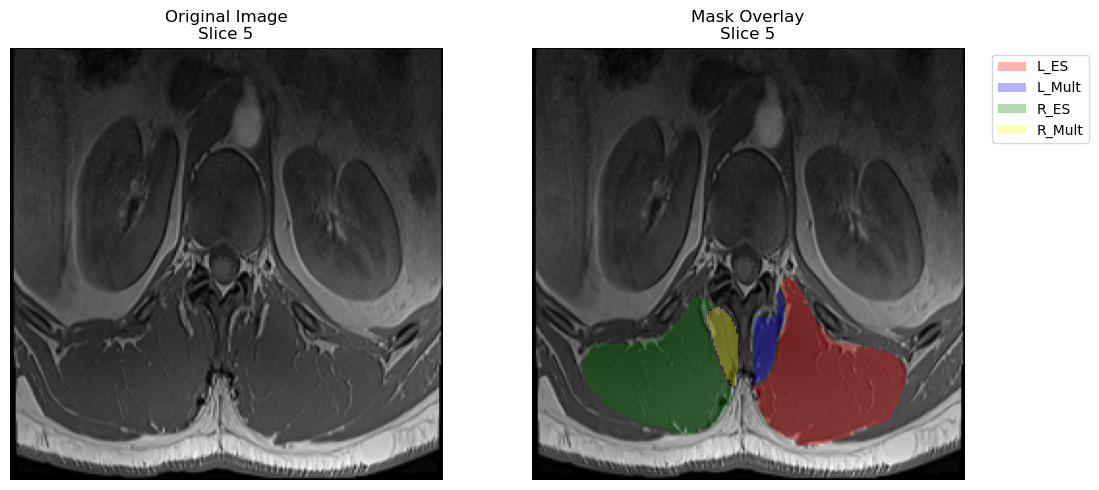

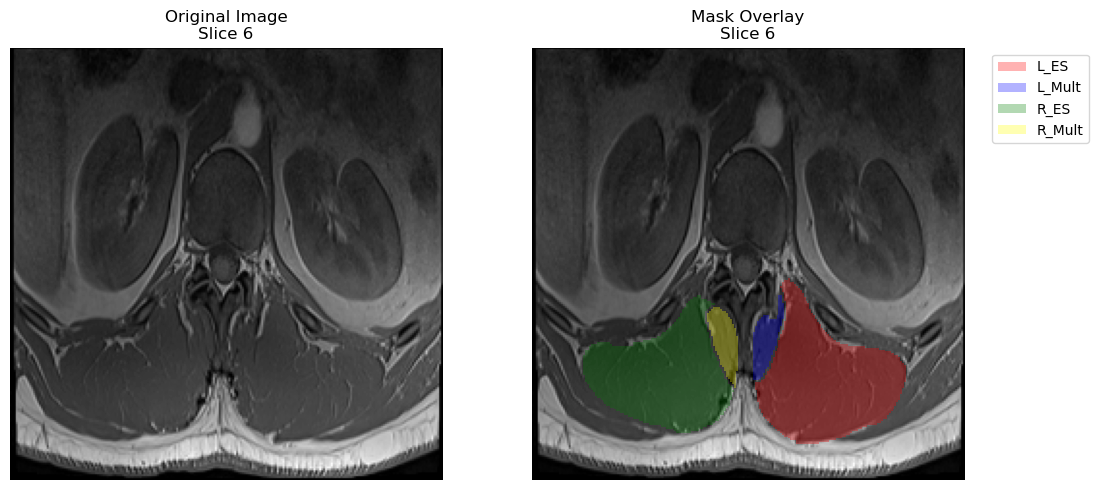

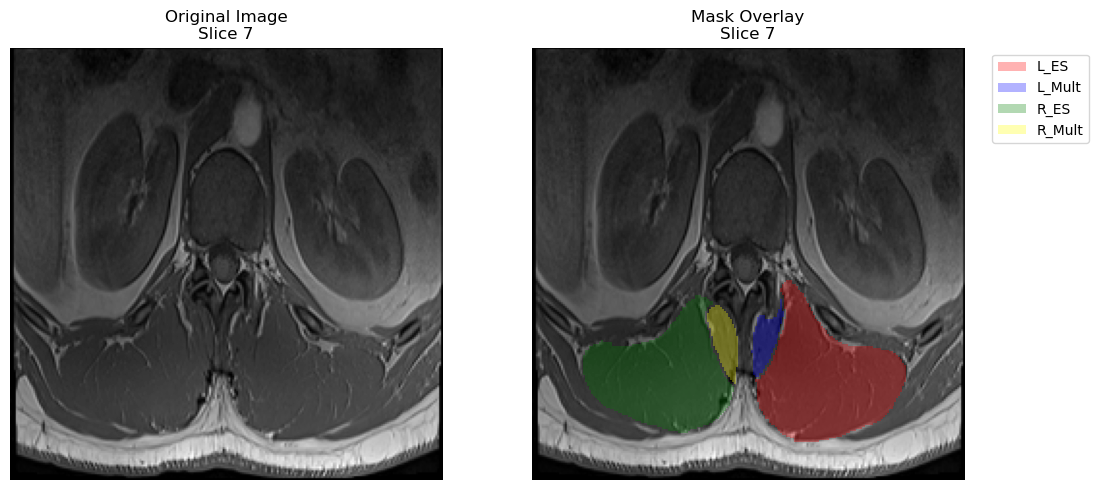

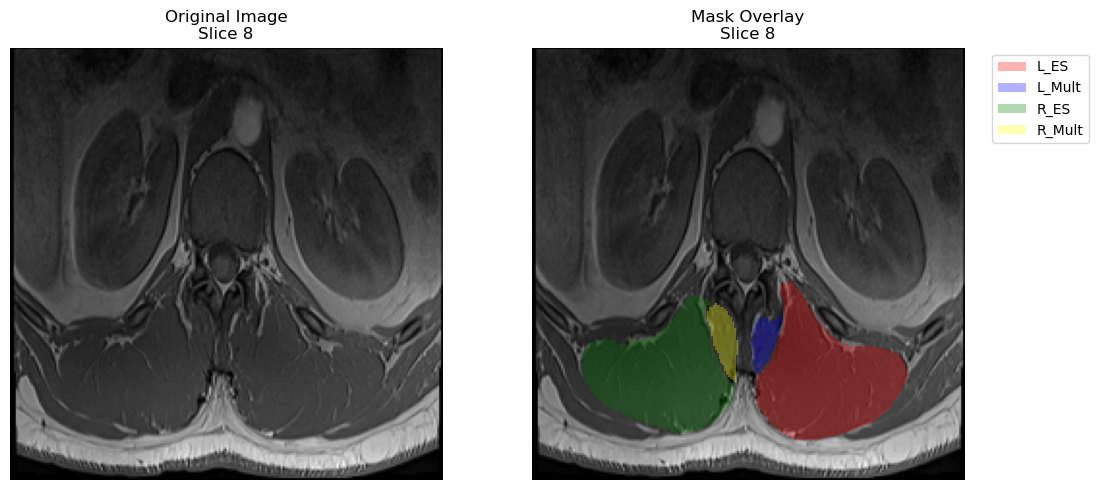

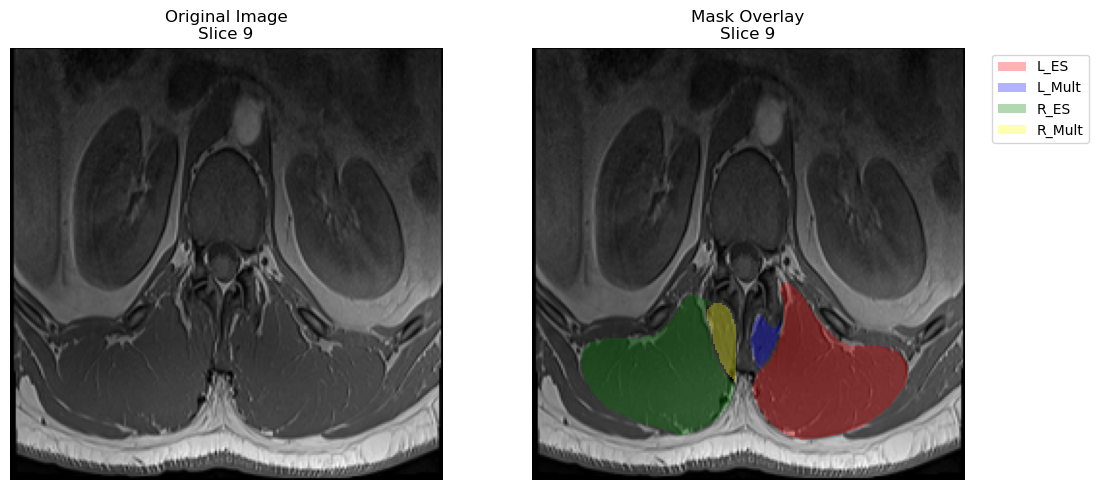

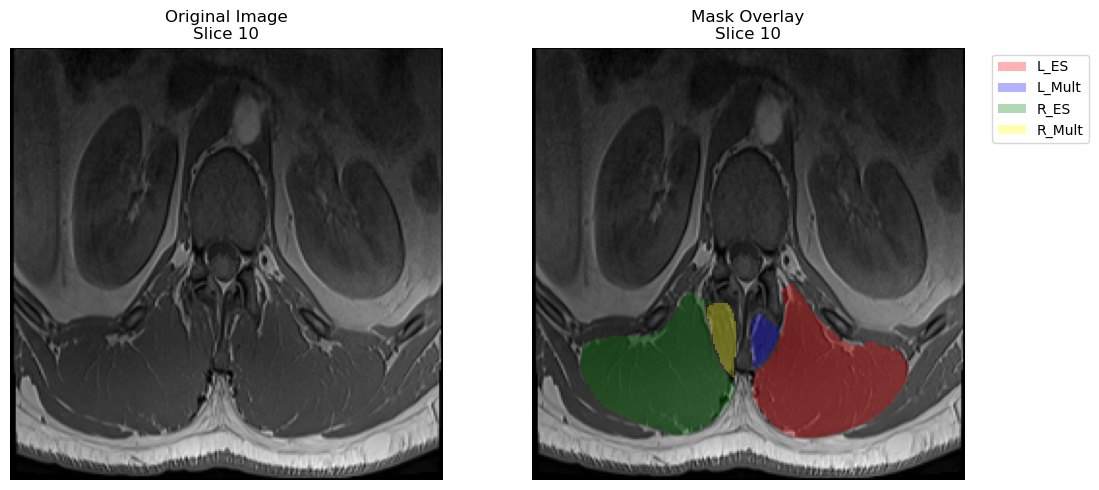

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

class H5Visualizer:
    def __init__(self, h5_path):
        """Initialize visualizer with H5 file path."""
        self.h5_path = h5_path
        
        # Get total number of slices
        with h5py.File(h5_path, 'r') as f:
            self.total_slices = len([k for k in f.keys() if k.startswith('image_')])
        
        print(f"Total slices in file: {self.total_slices}")
        
        # Setup the visualization
        self.setup_plot()
        
    def setup_plot(self):
        """Setup the matplotlib figure and axes."""
        self.fig = plt.figure(figsize=(15, 8))
        
        # Create main axes for images
        self.ax_image = plt.axes([0.1, 0.25, 0.35, 0.7])  # Original image
        self.ax_overlay = plt.axes([0.55, 0.25, 0.35, 0.7])  # Overlay
        
        # Create slider for slice selection
        self.ax_slider = plt.axes([0.2, 0.1, 0.6, 0.03])
        self.slider = Slider(
            self.ax_slider, 'Slice', 0, self.total_slices-1,
            valinit=0, valstep=1
        )
        
        # Create navigation buttons
        self.ax_prev = plt.axes([0.2, 0.02, 0.1, 0.04])
        self.ax_next = plt.axes([0.7, 0.02, 0.1, 0.04])
        self.btn_prev = Button(self.ax_prev, 'Previous')
        self.btn_next = Button(self.ax_next, 'Next')
        
        # Setup event handlers
        self.slider.on_changed(self.update)
        self.btn_prev.on_clicked(self.prev_slice)
        self.btn_next.on_clicked(self.next_slice)
        
        # Initial display
        self.current_slice = 0
        self.update(0)
        
    def load_slice(self, slice_idx):
        """Load a specific slice from the H5 file."""
        with h5py.File(self.h5_path, 'r') as f:
            image = f[f'image_{slice_idx}'][()]
            masks = f[f'mask_{slice_idx}'][()]
        return image, masks
    
    def update(self, value):
        """Update the display with a new slice."""
        slice_idx = int(value)
        self.current_slice = slice_idx
        
        try:
            # Load data
            image, masks = self.load_slice(slice_idx)
            
            # Clear previous plots
            self.ax_image.clear()
            self.ax_overlay.clear()
            
            # Show original image
            self.ax_image.imshow(image[0], cmap='gray')
            self.ax_image.set_title(f'Original Image (Slice {slice_idx})')
            self.ax_image.axis('off')
            
            # Show overlay
            self.ax_overlay.imshow(image[0], cmap='gray')
            colors = ['red', 'blue', 'green', 'yellow']
            mask_names = ['L_ES', 'L_Mult', 'R_ES', 'R_Mult']
            
            legend_elements = []
            
            for idx, (mask, color, name) in enumerate(zip(masks, colors, mask_names)):
                mask_overlay = np.ma.masked_where(mask < 0.5, mask)
                overlay = self.ax_overlay.imshow(mask_overlay, alpha=0.3, 
                                               cmap=plt.cm.colors.ListedColormap([color]))
                # Create patch for legend
                from matplotlib.patches import Patch
                legend_elements.append(Patch(facecolor=color, alpha=0.3, label=name))
            
            # Add legend with the patches
            self.ax_overlay.legend(handles=legend_elements, 
                                 bbox_to_anchor=(1.05, 1), 
                                 loc='upper left')
            
            self.ax_overlay.set_title(f'Mask Overlay (Slice {slice_idx})')
            self.ax_overlay.axis('off')
            
            plt.draw()
            
        except Exception as e:
            print(f"Error loading slice {slice_idx}: {str(e)}")

    
    def prev_slice(self, event):
        """Go to previous slice."""
        new_slice = max(0, self.current_slice - 1)
        self.slider.set_val(new_slice)
    
    def next_slice(self, event):
        """Go to next slice."""
        new_slice = min(self.total_slices - 1, self.current_slice + 1)
        self.slider.set_val(new_slice)
    
    def show(self):
        """Display the visualization."""
        plt.show()

def batch_view(h5_path, start_idx=0, num_slices=5):
    """View multiple slices at once."""
    with h5py.File(h5_path, 'r') as f:
        total_slices = len([k for k in f.keys() if k.startswith('image_')])
        end_idx = min(start_idx + num_slices, total_slices)
        
        for slice_idx in range(start_idx, end_idx):
            # Load data
            image = f[f'image_{slice_idx}'][()]
            masks = f[f'mask_{slice_idx}'][()]
            
            # Create figure
            plt.figure(figsize=(12, 5))
            
            # Show original image
            plt.subplot(121)
            plt.imshow(image[0], cmap='gray')
            plt.title(f'Original Image\nSlice {slice_idx}')
            plt.axis('off')
            
            # Show overlay
            ax = plt.subplot(122)
            plt.imshow(image[0], cmap='gray')
            colors = ['red', 'blue', 'green', 'yellow']
            mask_names = ['L_ES', 'L_Mult', 'R_ES', 'R_Mult']
            
            legend_elements = []
            
            for idx, (mask, color, name) in enumerate(zip(masks, colors, mask_names)):
                mask_overlay = np.ma.masked_where(mask < 0.5, mask)
                plt.imshow(mask_overlay, alpha=0.3, 
                         cmap=plt.cm.colors.ListedColormap([color]))
                # Create patch for legend
                from matplotlib.patches import Patch
                legend_elements.append(Patch(facecolor=color, alpha=0.3, label=name))
            
            # Add legend with the patches
            ax.legend(handles=legend_elements, 
                     bbox_to_anchor=(1.05, 1), 
                     loc='upper left')
            
            plt.title(f'Mask Overlay\nSlice {slice_idx}')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()

def main():
    h5_path = "/Volumes/advent/test/preprocessed_data.h5"
    
    print("\nChoose visualization mode:")
    print("1. Interactive viewer")
    print("2. Batch view")
    
    choice = input("Enter choice (1 or 2): ")
    
    if choice == "1":
        # Interactive visualization
        visualizer = H5Visualizer(h5_path)
        visualizer.show()
    elif choice == "2":
        # Batch visualization
        start_idx = int(input("Enter starting slice index: "))
        num_slices = int(input("Enter number of slices to view: "))
        batch_view(h5_path, start_idx, num_slices)
    else:
        print("Invalid choice!")

if __name__ == "__main__":
    main()

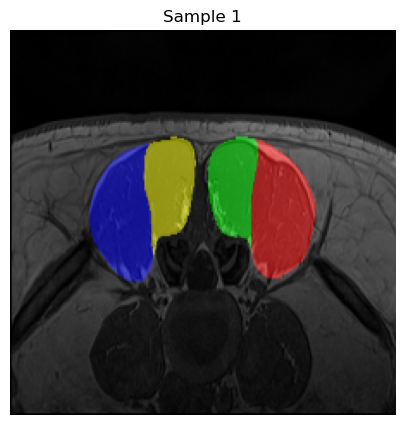

Mask Channel 1 Unique Values: [0.0000000e+00 1.5822034e-04 5.2334421e-04 6.4505218e-04 7.1807695e-04
 7.4241852e-04 7.6676015e-04 9.3715126e-04 1.1805672e-03 1.3509584e-03
 1.3631291e-03 1.9351565e-03 2.4463299e-03 2.6897457e-03 3.1035529e-03
 3.7120928e-03 3.8824838e-03 3.9555086e-03 4.0772166e-03 4.0893871e-03
 4.1989246e-03 4.6857563e-03 4.8561473e-03 5.0508804e-03 5.3673210e-03
 6.0488852e-03 6.2923012e-03 6.8156454e-03 6.9008409e-03 7.8988466e-03
 7.9962127e-03 8.0692377e-03 8.1666037e-03 8.3856778e-03 8.4343618e-03
 8.6534359e-03 9.5419036e-03 1.0040906e-02 1.0186956e-02 1.2268162e-02
 1.2718481e-02 1.2815848e-02 1.4994420e-02 1.6459897e-02 1.6613135e-02
 1.7720679e-02 1.7908223e-02 2.4297943e-02 3.6086652e-02 3.6838818e-02
 4.6889525e-02 4.8561882e-02 5.1519331e-02 5.4287054e-02 5.8035713e-02
 6.3865468e-02 7.4461550e-02 8.1080042e-02 8.4821425e-02 8.7786123e-02
 8.9933217e-02 1.0683614e-01 1.1058474e-01 1.3392857e-01 1.4030361e-01
 1.5075120e-01 1.5216056e-01 1.6511039e-01 1.69

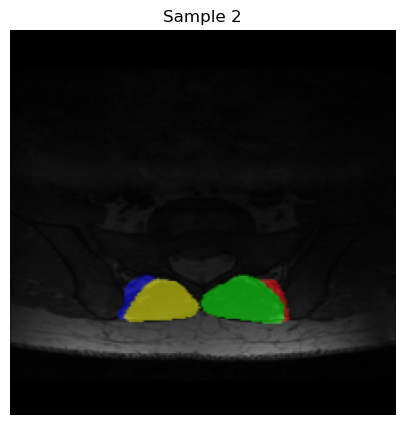

Mask Channel 1 Unique Values: [0.         0.00255102 0.01785714 0.02295918 0.02806122 0.03316326
 0.03571429 0.03826531 0.04336735 0.05357143 0.05867347 0.08418367
 0.10459184 0.11479592 0.14030612 0.17091836 0.17857143 0.19132653
 0.19642857 0.23214285 0.24234694 0.25       0.2984694  0.30867347
 0.32142857 0.36479592 0.36989796 0.375      0.39285713 0.4362245
 0.4642857  0.4719388  0.53571427 0.56377554 0.60714287 0.61989796
 0.625      0.63010204 0.6352041  0.64540815 0.70153064 0.75
 0.75765306 0.7627551  0.76785713 0.78571427 0.8214286  0.8341837
 0.8596939  0.9005102  0.91071427 0.93622446 0.94132656 0.9464286
 0.9566327  0.9617347  0.96428573 0.9719388  0.9770408  0.99234694
 0.997449   1.        ]
Mask Channel 2 Unique Values: [0.         0.00255102 0.00765306 0.0127551  0.01785714 0.02806122
 0.03571429 0.03826531 0.05867347 0.06887755 0.07142857 0.08418367
 0.08928572 0.09948979 0.10714286 0.11479592 0.125      0.14030612
 0.16071428 0.16581632 0.17602041 0.17857143 0.2142857

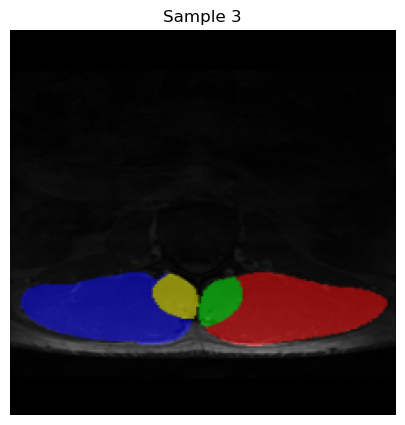

Mask Channel 1 Unique Values: [0.         0.00765306 0.0127551  0.01785714 0.02295918 0.02806122
 0.03316326 0.03571429 0.03826531 0.04336735 0.04846939 0.05357143
 0.06377551 0.06887755 0.07142857 0.08418367 0.08928572 0.09948979
 0.10714286 0.125      0.13010204 0.14030612 0.16071428 0.17602041
 0.17857143 0.19642857 0.20663266 0.21428572 0.21683674 0.23214285
 0.2372449  0.25       0.25255102 0.26785713 0.29336736 0.2984694
 0.30357143 0.30867347 0.34438777 0.35459185 0.35714287 0.36989796
 0.38010204 0.39285713 0.4107143  0.42091838 0.43112245 0.4362245
 0.44642857 0.4719388  0.47704083 0.48214287 0.49744898 0.5
 0.502551   0.5229592  0.5280612  0.53316325 0.5688776  0.5739796
 0.58928573 0.60714287 0.6096939  0.63010204 0.6352041  0.64285713
 0.64540815 0.65561223 0.6785714  0.6811224  0.69132656 0.6964286
 0.70153064 0.7066327  0.73214287 0.747449   0.75       0.7627551
 0.76785713 0.78571427 0.7933673  0.8035714  0.80867344 0.8214286
 0.82908165 0.83928573 0.8596939  0.86989796 

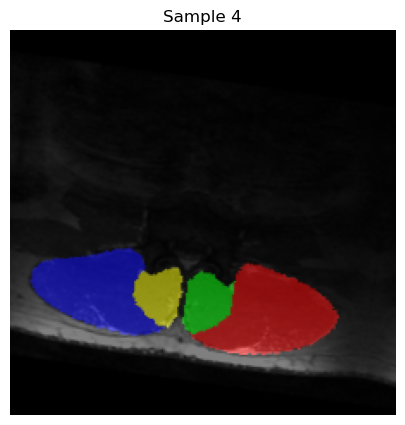

Mask Channel 1 Unique Values: [0.         0.00255102 0.00765306 0.0127551  0.01785714 0.02295918
 0.02806122 0.03316326 0.03571429 0.03826531 0.04336735 0.04846939
 0.05357143 0.05867347 0.06377551 0.06887755 0.07142857 0.08418367
 0.08928572 0.10459184 0.10714286 0.11479592 0.125      0.13010204
 0.14030612 0.14540817 0.16071428 0.16581632 0.17091836 0.17602041
 0.19132653 0.19642857 0.21428572 0.2372449  0.24234694 0.25255102
 0.26785713 0.29336736 0.2984694  0.30357143 0.30867347 0.31887755
 0.32142857 0.34438777 0.35459185 0.35714287 0.36989796 0.375
 0.38010204 0.39285713 0.4107143  0.4260204  0.43112245 0.47704083
 0.48214287 0.49744898 0.5        0.502551   0.51785713 0.5229592
 0.5280612  0.53316325 0.53571427 0.5535714  0.56377554 0.58928573
 0.60714287 0.6096939  0.61989796 0.6352041  0.64285713 0.64540815
 0.66071427 0.6785714  0.70153064 0.7066327  0.73214287 0.747449
 0.75765306 0.7627551  0.76785713 0.78571427 0.7933673  0.8035714
 0.8214286  0.8239796  0.8341837  0.85969

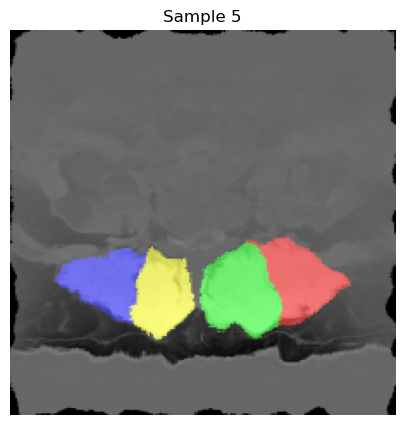

Mask Channel 1 Unique Values: [0.         0.00765306 0.0127551  0.01785714 0.02295918 0.02806122
 0.03316326 0.03571429 0.03826531 0.04336735 0.05357143 0.06887755
 0.07142857 0.08928572 0.09948979 0.10714286 0.11479592 0.125
 0.14030612 0.14540817 0.16071428 0.16581632 0.17091836 0.17602041
 0.17857143 0.19132653 0.19642857 0.20663266 0.23214285 0.2372449
 0.25       0.25255102 0.26785713 0.29336736 0.2984694  0.30357143
 0.32142857 0.34438777 0.35714287 0.36989796 0.39030612 0.39285713
 0.4107143  0.42091838 0.4260204  0.4362245  0.4642857  0.46683672
 0.47704083 0.5        0.502551   0.51785713 0.5229592  0.53316325
 0.53571427 0.5688776  0.5739796  0.57908165 0.58928573 0.60714287
 0.6096939  0.625      0.6352041  0.64285713 0.6785714  0.69132656
 0.6964286  0.7066327  0.73214287 0.747449   0.75       0.75765306
 0.7627551  0.78316325 0.8035714  0.80867344 0.8214286  0.85459185
 0.875      0.8852041  0.89285713 0.89540815 0.9005102  0.91071427
 0.9158163  0.9285714  0.9311224  0.94

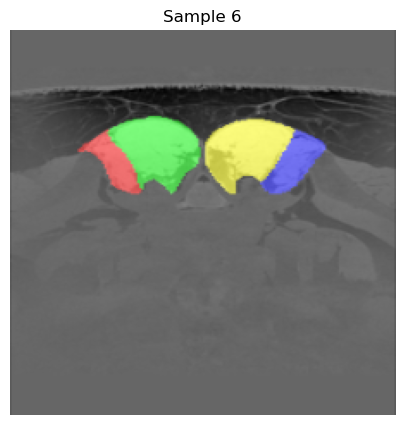

Mask Channel 1 Unique Values: [0.         0.00255102 0.01785714 0.02295918 0.02806122 0.03316326
 0.03826531 0.05357143 0.05867347 0.06377551 0.06887755 0.09948979
 0.10459184 0.10714286 0.11479592 0.14030612 0.16071428 0.17091836
 0.17857143 0.19132653 0.19642857 0.20663266 0.2372449  0.24234694
 0.25255102 0.26785713 0.2984694  0.30357143 0.31887755 0.32142857
 0.34438777 0.35714287 0.36479592 0.39030612 0.39285713 0.4107143
 0.4260204  0.43112245 0.4362245  0.44642857 0.4642857  0.47704083
 0.48214287 0.49744898 0.5        0.51785713 0.53571427 0.5535714
 0.5688776  0.58928573 0.61989796 0.6352041  0.64285713 0.64540815
 0.66071427 0.6785714  0.6811224  0.6964286  0.7066327  0.75
 0.75765306 0.7627551  0.78316325 0.78571427 0.8035714  0.80867344
 0.8239796  0.82908165 0.8341837  0.83928573 0.8596939  0.86989796
 0.89285713 0.9005102  0.9158163  0.9285714  0.9311224  0.94132656
 0.9464286  0.95153064 0.9617347  0.96428573 0.96683675 0.9719388
 0.9770408  0.98214287 0.9872449  0.99234

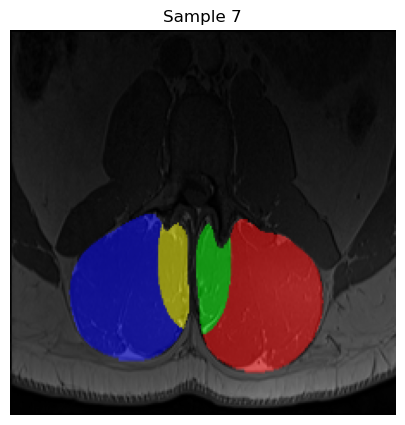

Mask Channel 1 Unique Values: [0.00000000e+00 3.65123851e-05 8.51955701e-05 1.33878755e-04
 1.82561940e-04 2.55586696e-04 6.69393747e-04 6.93735376e-04
 7.18076946e-04 9.12809686e-04 9.37151257e-04 9.61492828e-04
 1.13188394e-03 1.27793348e-03 1.32661674e-03 1.36312912e-03
 1.42398314e-03 1.71608222e-03 1.78910699e-03 1.86213176e-03
 1.93515653e-03 2.13476294e-03 2.37330515e-03 2.59237946e-03
 2.81145377e-03 3.07921134e-03 3.10355285e-03 3.32262716e-03
 3.68775101e-03 3.95550858e-03 4.07721661e-03 4.08938713e-03
 4.19892464e-03 4.34497418e-03 4.44234023e-03 4.49102372e-03
 4.68575628e-03 5.05088037e-03 5.17258793e-03 5.19692991e-03
 5.48663270e-03 6.38966775e-03 6.81564538e-03 6.82781637e-03
 7.11991545e-03 7.36333150e-03 7.55806407e-03 7.75279664e-03
 8.14476702e-03 8.26396979e-03 8.43436178e-03 9.11592599e-03
 9.31065902e-03 9.33500007e-03 9.74880718e-03 9.96788125e-03
 1.03086643e-02 1.12336446e-02 1.19395507e-02 1.22681623e-02
 1.29376370e-02 1.35217542e-02 1.40816104e-02 1.4860541

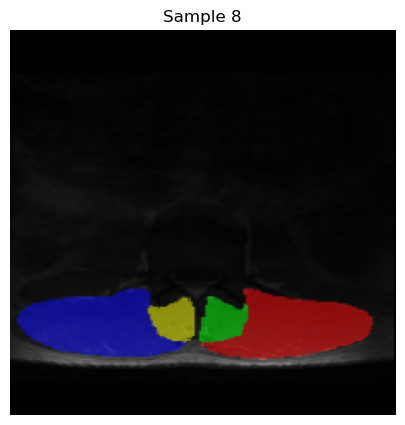

Mask Channel 1 Unique Values: [0.         0.00765306 0.0127551  0.02295918 0.02806122 0.03316326
 0.03571429 0.03826531 0.04336735 0.04846939 0.05357143 0.06377551
 0.06887755 0.07142857 0.08928572 0.09948979 0.10714286 0.14030612
 0.16071428 0.16581632 0.17602041 0.17857143 0.19132653 0.19642857
 0.20663266 0.21428572 0.23214285 0.2372449  0.29336736 0.2984694
 0.30357143 0.30867347 0.31887755 0.32142857 0.3392857  0.34438777
 0.35714287 0.36479592 0.36989796 0.375      0.38010204 0.39030612
 0.39285713 0.43112245 0.4362245  0.46683672 0.48214287 0.49744898
 0.5        0.502551   0.53571427 0.5688776  0.5739796  0.58928573
 0.625      0.64285713 0.64540815 0.6811224  0.69132656 0.6964286
 0.70153064 0.73214287 0.747449   0.75       0.75765306 0.7627551
 0.78316325 0.78571427 0.7933673  0.8035714  0.8214286  0.8239796
 0.82908165 0.83928573 0.875      0.8852041  0.89285713 0.9005102
 0.91071427 0.9285714  0.9311224  0.93622446 0.94132656 0.9464286
 0.95153064 0.9566327  0.9617347  0.96

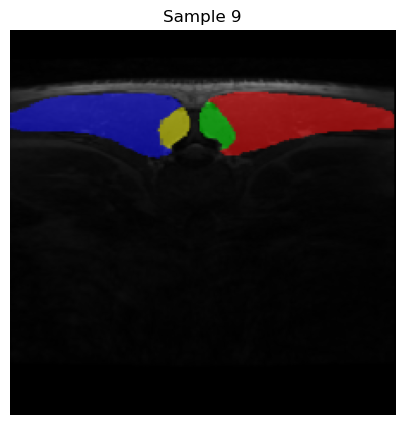

Mask Channel 1 Unique Values: [0.         0.00255102 0.02295918 0.02806122 0.03316326 0.03571429
 0.03826531 0.04336735 0.04846939 0.05867347 0.06377551 0.06887755
 0.07142857 0.08418367 0.08928572 0.10459184 0.10714286 0.11479592
 0.13010204 0.14030612 0.16581632 0.17091836 0.17857143 0.19132653
 0.20663266 0.21428572 0.21683674 0.2372449  0.24234694 0.25255102
 0.26785713 0.30357143 0.30867347 0.31887755 0.32142857 0.35714287
 0.38010204 0.39030612 0.39285713 0.42091838 0.4260204  0.43112245
 0.4362245  0.46683672 0.4719388  0.47704083 0.5229592  0.53316325
 0.56377554 0.5739796  0.57908165 0.58928573 0.60714287 0.61989796
 0.63010204 0.6352041  0.64285713 0.64540815 0.6811224  0.69132656
 0.70153064 0.7066327  0.73214287 0.747449   0.7627551  0.78316325
 0.78571427 0.80867344 0.8214286  0.8239796  0.8341837  0.85459185
 0.8852041  0.89285713 0.89540815 0.9005102  0.91071427 0.9158163
 0.9285714  0.9311224  0.9566327  0.9617347  0.96428573 0.96683675
 0.9719388  0.9770408  0.98214287

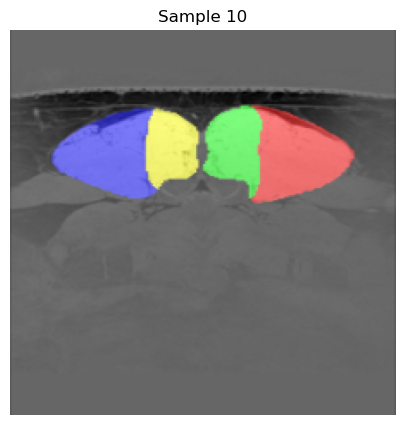

Mask Channel 1 Unique Values: [0.         0.00765306 0.0127551  0.02295918 0.02806122 0.03316326
 0.03571429 0.03826531 0.04336735 0.04846939 0.05357143 0.06377551
 0.06887755 0.07142857 0.08418367 0.08928572 0.09948979 0.10714286
 0.11479592 0.125      0.14540817 0.16071428 0.16581632 0.17091836
 0.19132653 0.19642857 0.20663266 0.21428572 0.23214285 0.2372449
 0.25       0.25255102 0.26785713 0.29336736 0.2984694  0.30357143
 0.30867347 0.31887755 0.32142857 0.3392857  0.34438777 0.35714287
 0.375      0.39030612 0.4107143  0.4260204  0.4362245  0.44642857
 0.4642857  0.46683672 0.4719388  0.47704083 0.48214287 0.49744898
 0.5        0.51785713 0.5280612  0.53316325 0.53571427 0.56377554
 0.5739796  0.57908165 0.58928573 0.60714287 0.625      0.63010204
 0.6352041  0.64285713 0.64540815 0.65561223 0.66071427 0.6785714
 0.6811224  0.69132656 0.70153064 0.7066327  0.73214287 0.747449
 0.75       0.7627551  0.76785713 0.78316325 0.78571427 0.7933673
 0.8214286  0.82908165 0.8341837  0.8

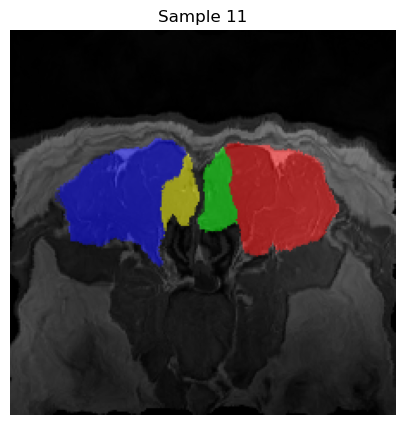

Mask Channel 1 Unique Values: [0.00000000e+00 1.82561940e-04 2.55586696e-04 8.15443287e-04
 8.39784916e-04 1.36312912e-03 1.76476536e-03 3.49301845e-03
 4.08938713e-03 4.68575628e-03 4.90483083e-03 5.29429596e-03
 5.75678609e-03 6.26795972e-03 6.73044985e-03 6.81564538e-03
 7.89884664e-03 8.06923769e-03 8.09357874e-03 8.43436178e-03
 9.09158401e-03 9.54190362e-03 1.05764214e-02 1.08441785e-02
 1.15500847e-02 1.17204757e-02 1.21829668e-02 1.28158480e-02
 1.29862390e-02 1.43980514e-02 1.49944201e-02 1.72460172e-02
 1.77206788e-02 2.74331626e-02 4.99760620e-02 5.76534122e-02
 5.76924011e-02 6.34881780e-02 6.69520050e-02 7.92981461e-02
 8.77861232e-02 1.20535716e-01 1.30895600e-01 1.47321433e-01
 1.50797382e-01 1.52160555e-01 1.54818639e-01 1.68949127e-01
 1.69642851e-01 1.86988741e-01 1.87500000e-01 2.01411247e-01
 2.05357149e-01 2.06440344e-01 2.23214284e-01 2.25190744e-01
 2.26001367e-01 2.36334488e-01 2.41071433e-01 2.54340172e-01
 2.57767409e-01 2.58928567e-01 2.59150028e-01 2.7489924

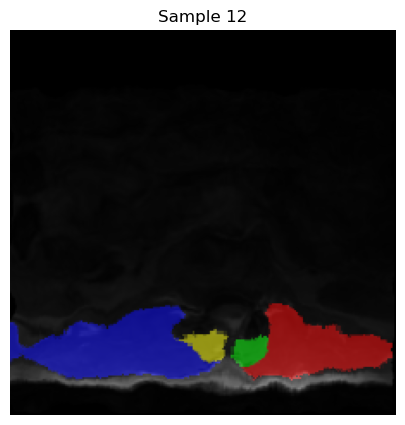

Mask Channel 1 Unique Values: [0.         0.00765306 0.0127551  0.01785714 0.02295918 0.02806122
 0.03316326 0.03571429 0.03826531 0.05357143 0.06377551 0.06887755
 0.07142857 0.08418367 0.08928572 0.09948979 0.11479592 0.16071428
 0.17091836 0.17602041 0.17857143 0.19642857 0.20663266 0.21428572
 0.23214285 0.24234694 0.25       0.26785713 0.29336736 0.2984694
 0.30357143 0.3392857  0.35714287 0.36479592 0.39030612 0.39285713
 0.44642857 0.4642857  0.46683672 0.48214287 0.5        0.51785713
 0.5229592  0.5280612  0.53316325 0.5739796  0.58928573 0.60714287
 0.625      0.63010204 0.64285713 0.64540815 0.65561223 0.6811224
 0.69132656 0.6964286  0.70153064 0.7066327  0.76785713 0.78571427
 0.7933673  0.8035714  0.8214286  0.83928573 0.875      0.8852041
 0.91071427 0.9158163  0.9285714  0.93622446 0.9464286  0.95153064
 0.9617347  0.96428573 0.96683675 0.9719388  0.9770408  0.98214287
 0.9872449  0.99234694 1.        ]
Mask Channel 2 Unique Values: [0.         0.0127551  0.02295918 0.0

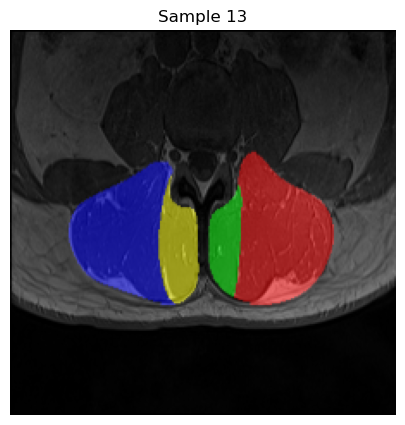

Mask Channel 1 Unique Values: [0.0000000e+00 6.0853978e-05 2.3124511e-04 4.5031944e-04 7.4241852e-04
 7.6676015e-04 9.3715126e-04 1.0345177e-03 1.1318839e-03 1.1562256e-03
 1.3022751e-03 1.3631291e-03 1.4483246e-03 1.4970079e-03 1.7647654e-03
 1.9594980e-03 2.0812061e-03 2.3002804e-03 2.4706714e-03 2.5923795e-03
 2.6167210e-03 2.6654042e-03 2.8114538e-03 2.9575033e-03 3.0792113e-03
 3.1035529e-03 3.1765776e-03 3.4686767e-03 3.6634095e-03 3.8338006e-03
 4.0528751e-03 4.0893871e-03 4.1502411e-03 4.2719492e-03 4.4910237e-03
 5.0265384e-03 5.2942960e-03 5.5863950e-03 5.7811281e-03 5.8054696e-03
 5.8784941e-03 6.0245437e-03 6.1705932e-03 6.2923012e-03 6.8156454e-03
 7.0712324e-03 8.4343618e-03 8.6534359e-03 8.7021189e-03 9.2376340e-03
 9.5419036e-03 9.6514411e-03 9.9678813e-03 1.0040906e-02 1.1757070e-02
 1.2268162e-02 1.3789511e-02 1.4714492e-02 1.4994420e-02 1.7720679e-02
 2.5865553e-02 3.1456850e-02 3.8406428e-02 5.8308318e-02 6.0352959e-02
 6.5408736e-02 7.3524341e-02 8.0936469e-02 8.24

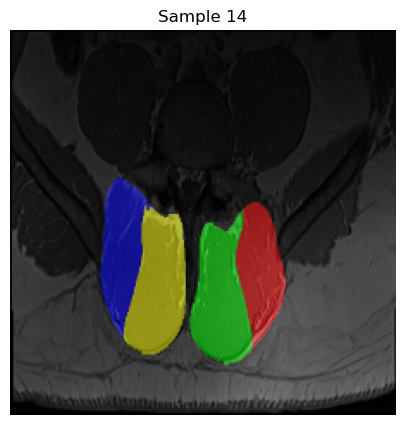

Mask Channel 1 Unique Values: [0.00000000e+00 1.82561940e-04 2.55586696e-04 3.28611495e-04
 4.74661036e-04 5.47685777e-04 5.96368976e-04 9.37151257e-04
 9.85834398e-04 1.13188394e-03 1.18056720e-03 1.27793348e-03
 1.30227511e-03 1.36312912e-03 1.86213176e-03 2.00818130e-03
 2.12988933e-03 2.22725561e-03 2.27593887e-03 2.81145377e-03
 2.88447854e-03 3.15223611e-03 3.32262716e-03 3.54170147e-03
 3.61472624e-03 3.63906799e-03 3.67803057e-03 3.83380055e-03
 3.95550858e-03 4.08938713e-03 4.71009780e-03 5.41600399e-03
 5.53771202e-03 6.02454366e-03 6.63308380e-03 6.81564538e-03
 6.90084090e-03 7.92318769e-03 8.38567782e-03 8.43436178e-03
 9.54190362e-03 9.74880718e-03 1.01869563e-02 1.08441785e-02
 1.13796936e-02 1.21829668e-02 1.22681623e-02 1.27184810e-02
 1.37895113e-02 1.39599834e-02 1.40572693e-02 1.49944201e-02
 1.50309326e-02 1.72460172e-02 1.77206788e-02 1.78497378e-02
 2.18564607e-02 2.21972428e-02 2.26986688e-02 2.52837781e-02
 4.38029915e-02 4.81115058e-02 5.76534122e-02 6.8191006

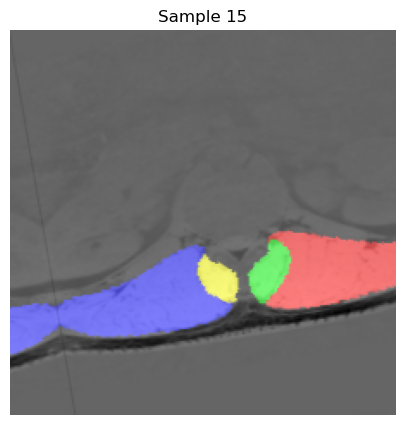

Mask Channel 1 Unique Values: [0.         0.00255102 0.00765306 0.0127551  0.01785714 0.02295918
 0.02806122 0.03316326 0.03571429 0.03826531 0.04336735 0.05357143
 0.05867347 0.06377551 0.06887755 0.07142857 0.08928572 0.09948979
 0.11479592 0.14030612 0.16071428 0.17091836 0.17857143 0.20663266
 0.21428572 0.21683674 0.23214285 0.24234694 0.25       0.25255102
 0.26785713 0.2984694  0.30867347 0.32142857 0.35459185 0.35714287
 0.36479592 0.375      0.38010204 0.39285713 0.4107143  0.46683672
 0.4719388  0.47704083 0.48214287 0.5        0.502551   0.51785713
 0.5280612  0.53316325 0.56377554 0.5739796  0.58928573 0.60714287
 0.6096939  0.61989796 0.63010204 0.6352041  0.64285713 0.65561223
 0.6785714  0.69132656 0.70153064 0.7066327  0.73214287 0.75
 0.75765306 0.7627551  0.78571427 0.7933673  0.8035714  0.80867344
 0.8214286  0.8239796  0.82908165 0.8341837  0.83928573 0.875
 0.8852041  0.9005102  0.91071427 0.9158163  0.9285714  0.93622446
 0.9464286  0.9566327  0.9617347  0.9642857

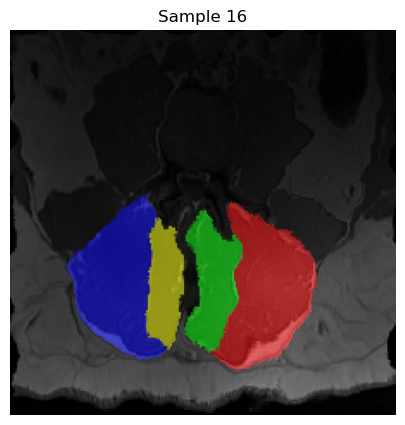

Mask Channel 1 Unique Values: [0.00000000e+00 3.65123851e-05 6.08539776e-05 1.09537163e-04
 4.01636265e-04 4.50319436e-04 7.66760146e-04 7.91101716e-04
 9.85834398e-04 1.03451766e-03 1.10754243e-03 1.15622557e-03
 1.25359197e-03 1.27793348e-03 1.36312912e-03 1.42398314e-03
 1.78910699e-03 2.00818130e-03 2.08120607e-03 2.51935469e-03
 2.64106272e-03 3.76077578e-03 3.95550858e-03 4.08938713e-03
 5.02653839e-03 5.19692991e-03 5.29429596e-03 5.36732096e-03
 6.24361821e-03 6.75479136e-03 6.81564538e-03 6.90084090e-03
 7.07123242e-03 7.58240558e-03 8.14476702e-03 8.21528677e-03
 8.30783416e-03 8.43436178e-03 8.92857183e-03 9.09158401e-03
 9.54190362e-03 9.96788125e-03 1.08441785e-02 1.21829668e-02
 1.22681623e-02 1.24507239e-02 1.29862390e-02 1.37651702e-02
 1.49944201e-02 2.65301280e-02 2.74331626e-02 3.07655651e-02
 4.89147268e-02 5.09473011e-02 5.72177395e-02 5.87853231e-02
 6.13388456e-02 6.17332384e-02 7.44614452e-02 8.54347050e-02
 8.54712203e-02 9.10917819e-02 9.59308892e-02 1.0557268

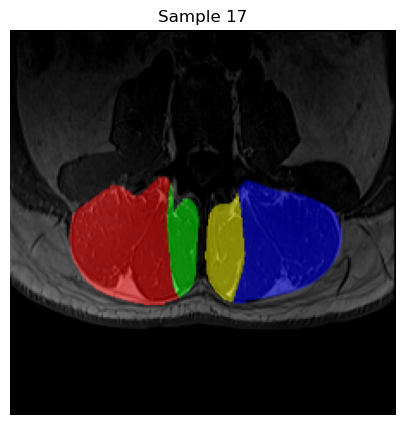

Mask Channel 1 Unique Values: [0.00000000e+00 1.09537163e-04 2.06903525e-04 3.04269895e-04
 5.23344206e-04 6.93735376e-04 7.91101716e-04 8.39784916e-04
 8.88468057e-04 9.12809686e-04 9.37151257e-04 9.61492828e-04
 1.08320080e-03 1.22925034e-03 1.27793348e-03 1.35095837e-03
 1.36312912e-03 1.61871582e-03 2.00818130e-03 2.30028038e-03
 2.51935469e-03 2.88447854e-03 2.95750331e-03 3.10355285e-03
 3.46867670e-03 3.63906799e-03 3.83380055e-03 4.08938713e-03
 4.15024115e-03 4.27194918e-03 4.32063220e-03 4.56404826e-03
 4.68575628e-03 4.92917234e-03 5.02653839e-03 5.05088037e-03
 5.36732096e-03 5.53771202e-03 5.85415261e-03 6.04888517e-03
 6.38966775e-03 6.46269228e-03 6.81564538e-03 6.90084090e-03
 7.41201453e-03 8.26396979e-03 8.38567782e-03 8.43436178e-03
 8.65343586e-03 9.50539112e-03 9.52973310e-03 9.54190362e-03
 9.65144113e-03 9.77314916e-03 1.02843223e-02 1.09172035e-02
 1.21829668e-02 1.22681623e-02 1.49944201e-02 1.64598972e-02
 1.77206788e-02 3.60866524e-02 4.62444760e-02 4.8561882

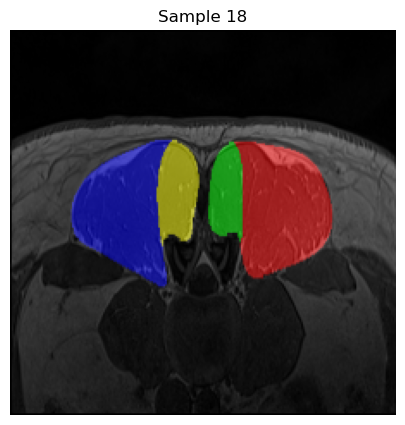

Mask Channel 1 Unique Values: [0.0000000e+00 2.7992830e-04 3.2861150e-04 4.2597784e-04 6.2071055e-04
 7.6676015e-04 9.1280969e-04 1.0345177e-03 1.1075424e-03 1.2779335e-03
 1.3631291e-03 1.4483246e-03 1.5700327e-03 1.8621318e-03 2.2515971e-03
 2.5923795e-03 2.7384290e-03 3.0061866e-03 3.1765776e-03 3.2252609e-03
 3.2496024e-03 3.3226272e-03 3.3469687e-03 3.8338006e-03 4.1989246e-03
 4.2719492e-03 4.3206322e-03 4.5640483e-03 4.6857563e-03 5.1482464e-03
 6.4870343e-03 6.5600588e-03 6.6817668e-03 6.8156454e-03 7.1199154e-03
 7.6310886e-03 7.9231877e-03 7.9962127e-03 8.0935787e-03 8.1666037e-03
 8.7021189e-03 8.8725099e-03 9.2376340e-03 9.3106590e-03 9.5419036e-03
 1.0576421e-02 1.0600763e-02 1.1379694e-02 1.2268162e-02 1.3521754e-02
 1.3765170e-02 1.4081610e-02 1.4994420e-02 1.7720679e-02 4.2259723e-02
 4.9379691e-02 5.4605864e-02 6.2329583e-02 6.3488178e-02 6.7986630e-02
 7.6211616e-02 7.9877555e-02 8.7786123e-02 1.0871771e-01 1.2264853e-01
 1.3471232e-01 1.4732143e-01 1.4820009e-01 1.49

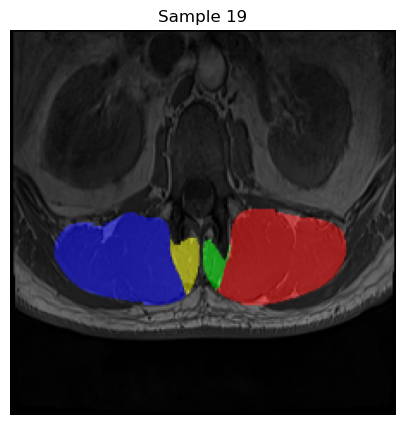

Mask Channel 1 Unique Values: [0.00000000e+00 8.51955701e-05 1.33878755e-04 2.31245111e-04
 2.79928296e-04 3.52953066e-04 4.25977836e-04 4.74661036e-04
 5.47685777e-04 7.91101716e-04 9.12809686e-04 1.03451766e-03
 1.15622557e-03 1.20490871e-03 1.22925034e-03 1.36312912e-03
 1.61871582e-03 1.88647327e-03 1.93515653e-03 2.00818130e-03
 2.30028038e-03 2.73842900e-03 2.81145377e-03 2.86013703e-03
 3.23745864e-03 3.32262716e-03 4.08938713e-03 4.44234023e-03
 4.68575628e-03 4.71009780e-03 5.02653839e-03 5.36732096e-03
 6.17059320e-03 6.81564538e-03 7.75279664e-03 8.38567782e-03
 8.43436178e-03 9.28631704e-03 9.50539112e-03 9.54190362e-03
 1.00531587e-02 1.02795297e-02 1.06251044e-02 1.15014017e-02
 1.17570702e-02 1.22681623e-02 1.29376370e-02 1.44809047e-02
 1.49944201e-02 1.64598972e-02 1.66131351e-02 1.77206788e-02
 2.27303356e-02 2.66031530e-02 3.01594753e-02 3.12500000e-02
 5.02657928e-02 5.46058640e-02 6.15115799e-02 6.24828488e-02
 8.24358985e-02 8.77861232e-02 8.96190926e-02 9.2583969

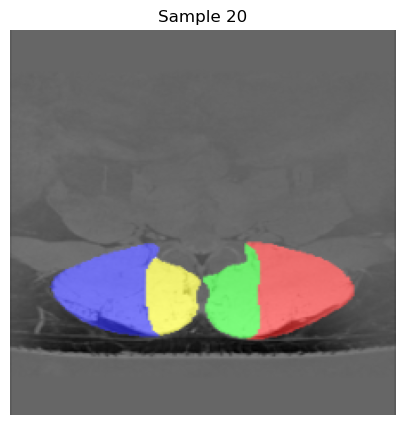

Mask Channel 1 Unique Values: [0.         0.00765306 0.01785714 0.02295918 0.02806122 0.03571429
 0.03826531 0.04336735 0.04846939 0.05357143 0.06377551 0.07142857
 0.08928572 0.09948979 0.10459184 0.10714286 0.11479592 0.13010204
 0.14540817 0.16071428 0.16581632 0.17091836 0.19132653 0.19642857
 0.21428572 0.23214285 0.2372449  0.24234694 0.25       0.25255102
 0.26785713 0.2984694  0.32142857 0.34438777 0.35714287 0.36989796
 0.375      0.39030612 0.4107143  0.43112245 0.44642857 0.4642857
 0.46683672 0.47704083 0.48214287 0.49744898 0.5        0.502551
 0.51785713 0.53316325 0.53571427 0.5535714  0.5688776  0.57908165
 0.58928573 0.625      0.63010204 0.6352041  0.64285713 0.64540815
 0.65561223 0.66071427 0.6785714  0.6811224  0.69132656 0.6964286
 0.70153064 0.7066327  0.747449   0.75       0.75765306 0.78316325
 0.78571427 0.8214286  0.82908165 0.8341837  0.83928573 0.86989796
 0.875      0.8852041  0.89285713 0.9005102  0.91071427 0.9158163
 0.9285714  0.9311224  0.9464286  0.9

In [5]:
import torch
import h5py
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A

# Define the augmentation pipeline without ToTensorV2
augmentation_transform = A.Compose([
    # Geometric transforms applied to both image and mask
    A.HorizontalFlip(p=0.1),
    A.VerticalFlip(p=0.1),
    A.RandomRotate90(p=0.1),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.1),
    A.ElasticTransform(alpha=20, sigma=6.0, p=0.1),
    A.GridDistortion(p=0.1),
    
    # Color transforms applied only to image
    A.RandomBrightnessContrast(p=0.1),
    A.Normalize(mean=(0.0,), std=(1.0,)),  # Normalize images
])

# Dataset for loading preprocessed data from HDF5 with augmentations
class PreprocessedHDF5Dataset(Dataset):
    def __init__(self, file_path, augmentation=None):
        self.file_path = file_path
        self.augmentation = augmentation

        with h5py.File(self.file_path, 'r') as f:
            # Sort keys to ensure correct pairing
            self.image_keys = sorted([key for key in f.keys() if key.startswith('image_')])
            self.mask_keys = sorted([key for key in f.keys() if key.startswith('mask_')])

        assert len(self.image_keys) == len(self.mask_keys), "Number of images and masks should be equal."

    def __len__(self):
        return len(self.image_keys)  # Assuming one image per mask

    def __getitem__(self, idx):
        with h5py.File(self.file_path, 'r') as f:
            image = f[self.image_keys[idx]][()]  # Shape: (1, H, W)
            mask = f[self.mask_keys[idx]][()]    # Shape: (4, H, W)

        # Convert the image and mask to the required format for augmentation
        image = image[0]  # Shape: (H, W)
        mask = mask.transpose(1, 2, 0)  # Shape: (H, W, 4)

        # Apply augmentation if provided
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented['image']  # Shape: (H, W)
            mask = augmented['mask']    # Shape: (H, W, 4)

        # Transpose the mask back to (4, H, W)
        mask = mask.transpose(2, 0, 1)  # Shape: (4, H, W)

        # Convert to PyTorch tensors manually
        image = torch.from_numpy(image).float().unsqueeze(0)  # Shape: (1, H, W)
        mask = torch.from_numpy(mask).float()  # Shape: (4, H, W)

        # Manually convert mask to desired data type
        mask = mask.float()  # Change to .long() if categorical

        return image, mask  # Both are torch.Tensor objects

# Function to visualize an image with overlaid masks
def visualize_image_with_masks(image, masks, alpha=0.5, title="Image with Masks"):
    """
    Visualizes a grayscale image with overlaid masks.

    Parameters:
    - image (torch.Tensor or numpy.ndarray): Grayscale image tensor of shape (1, H, W) or (H, W).
    - masks (torch.Tensor or numpy.ndarray): Masks tensor of shape (4, H, W).
    - alpha (float): Transparency factor for mask overlays.
    - title (str): Title for the plot.
    """
    # Convert tensors to numpy arrays if necessary
    if isinstance(image, torch.Tensor):
        image = image.squeeze(0).cpu().numpy()  # Shape: (H, W)
    if isinstance(masks, torch.Tensor):
        masks = masks.cpu().numpy()  # Shape: (4, H, W)

    # Normalize the image to [0, 1] for visualization
    image_min, image_max = image.min(), image.max()
    if image_max - image_min > 0:
        image = (image - image_min) / (image_max - image_min)
    else:
        image = np.zeros_like(image)

    # Create an RGB version of the grayscale image
    image_rgb = np.stack([image, image, image], axis=-1)  # Shape: (H, W, 3)

    # Define distinct colors for each mask channel
    mask_colors = [
        (1, 0, 0),    # Red
        (0, 1, 0),    # Green
        (0, 0, 1),    # Blue
        (1, 1, 0)     # Yellow
    ]

    # Initialize an empty RGB mask
    mask_rgb = np.zeros_like(image_rgb)

    for i in range(masks.shape[0]):
        # Normalize each mask channel to [0, 1]
        mask = masks[i]
        mask_min, mask_max = mask.min(), mask.max()
        if mask_max - mask_min > 0:
            mask_normalized = (mask - mask_min) / (mask_max - mask_min)
        else:
            mask_normalized = np.zeros_like(mask)

        # Apply the color to the mask channel
        color = mask_colors[i % len(mask_colors)]
        for c in range(3):
            mask_rgb[..., c] += mask_normalized * color[c]

    # Ensure the mask RGB values are within [0, 1]
    mask_rgb = np.clip(mask_rgb, 0, 1)

    # Overlay the masks on the image using alpha blending
    overlay = (1 - alpha) * image_rgb + alpha * mask_rgb
    overlay = np.clip(overlay, 0, 1)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.imshow(overlay)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Function to validate mask integrity
def validate_masks(masks):
    """
    Validates the uniqueness of values in each mask channel.

    Parameters:
    - masks (torch.Tensor or numpy.ndarray): Masks tensor of shape (4, H, W).
    """
    if isinstance(masks, torch.Tensor):
        masks = masks.numpy()
    for i in range(masks.shape[0]):
        unique_values = np.unique(masks[i])
        print(f"Mask Channel {i+1} Unique Values: {unique_values}")

# Load the preprocessed dataset
data_path =  "/Volumes/advent/test/preprocessed_data.h5"  # Update this to your dataset path
batch_size = 20  # Small batch size for testing
preprocessed_dataset = PreprocessedHDF5Dataset(file_path=data_path, augmentation=augmentation_transform)

# DataLoader for augmented dataset
dataloader = DataLoader(preprocessed_dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # Set num_workers=0 for testing

# Loop through the DataLoader to fetch and display augmented samples
for batch_idx, (images, masks) in enumerate(dataloader):
    for i in range(len(images)):
        img = images[i]   # Shape: (1, H, W)
        msk = masks[i]    # Shape: (4, H, W)
        visualize_image_with_masks(img, msk, alpha=0.5, title=f"Sample {i+1}")
        validate_masks(msk)
    break  # Visualize only the first batch
